# CZII YOLO11 Submission Baseline
In [the previous training notebook](https://www.kaggle.com/code/itsuki9180/czii-yolo11-training-baseline) we built a model to find the xy coordinates of particles by using 2D object detection on sliced ​​images.

Now, what we can find is **the center of the circle**. But we need to find the coordinates of **the center of the sphere shaped particle**. How can we do this?

Here I propose to stack slices and consider points in the neighborhood of a given point to be points of the same sphere.

It requires some basic graph theory knowledge, but you'll get the hang of it quickly.

# Install and Import modules

In [ ]:
!tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
!pip install --no-index --find-links=./packages ultralytics
!rm -rf ./packages

./packages/
./packages/pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl
./packages/numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/psutil-6.1.0-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/nvidia_nvtx_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl
./packages/nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl
./packages/charset_normalizer-3.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl
./packages/torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl
./packages/matplotlib-3.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
./packages/tqdm-4.67.1-py3-none-any.whl
./packages/networkx-3.4.2-py3-none-any.whl
./packages/typing_extensions-4.12.2-py3-none-any.whl
./packages/fonttools-4.55.1

In [ ]:
!cp -r '/kaggle/input/hengck-czii-cryo-et-01/wheel_file' '/kaggle/working/' #파일을 작업 디렉토리로 복사
!pip install /kaggle/working/wheel_file/asciitree-0.3.3/asciitree-0.3.3
!pip install --no-index --find-links=/kaggle/working/wheel_file zarr #zarr는 대규모 데이터셋을 처리하는 데 유용한 라이브러리로, 특히 과학적 데이터나 시뮬레이션 결과를 저장하는 데 유용

Processing ./wheel_file/asciitree-0.3.3/asciitree-0.3.3
  Preparing metadata (setup.py) ... done
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=26a0dae23d3adbe909edd21b8843dea67df38b1802a533e9d42cd2ad09390a99
  Stored in directory: /root/.cache/pip/wheels/72/5f/18/c0251c9cff85c62eda5978bec3fd2e2bf68c30d9b89d523146
Successfully built asciitree
Looking in links: /kaggle/working/wheel_file
Processing ./wheel_file/zarr-2.18.3-py3-none-any.whl
Processing ./wheel_file/numcodecs-0.13.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from zarr)


In [ ]:
import zarr
from ultralytics import YOLO
from tqdm import tqdm
import glob, os
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

We use a recursive function in this notebook, and we change the settings to explore the graph deep enough.

In [ ]:
import sys
sys.setrecursionlimit(10000)

In [ ]:
import warnings
warnings.simplefilter('ignore')
np.warnings = warnings

# Prepare trained YOLO model

In [ ]:
model = YOLO("/kaggle/input/yolo11-histogram-matching-with-additional-data/runs/detect/train/weights/best.pt")

In [ ]:
runs = sorted(glob.glob('/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns/*'))
runs = [os.path.basename(x) for x in runs]
runs[:5]

['TS_5_4', 'TS_69_2', 'TS_6_4']

In [ ]:
#Information about labels

In [ ]:
particle_names = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']

In [ ]:
p2i_dict = {
        'apo-ferritin': 0,
        'beta-amylase': 1,
        'beta-galactosidase': 2,
        'ribosome': 3,
        'thyroglobulin': 4,
        'virus-like-particle': 5
    }

i2p = {v:k for k, v in p2i_dict.items()}

In [ ]:
particle_radius = {
        'apo-ferritin': 60,
        'beta-amylase': 65,
        'beta-galactosidase': 90,
        'ribosome': 150,
        'thyroglobulin': 130,
        'virus-like-particle': 135,
    }

# define Main process class
There are many variables and functions going back and forth. We can easily manage variables by defining classes.

In [ ]:
class PredAggForYOLO:
    def __init__(self, first_conf=0.2, final_conf=0.3, conf_coef=0.75):
        self.first_conf = first_conf # threshold of confidence yolo
        self.final_conf = final_conf # final threshold score (not be used in version 14)
        self.conf_coef = conf_coef # if found many points, give bonus
        self.particle_confs = [0.5, 0.0, 0.2, 0.5, 0.2, 0.5] # be strict to easy labels

    def convert_to_8bit(self, x): # 3D배열을 시각화를 위해 8비트 이미지로 변환(2d이미지)
        lower, upper = np.percentile(x, (0.5, 99.5))
        x = np.clip(x, lower, upper)
        x = (x - x.min()) / (x.max() - x.min() + 1e-12) * 255
        return x.round().astype("uint8")

    # depth first search.
    # aggregate the coordinates and confidence scores of connected graphs.
    def dfs(self, v): #그래프 탐색 알고리즘_깊이우선탐색을 사용하여 연결된 점들을 찾고 해당 점들의 신뢰도를 합산
        self.passed[v] = True
        self.conf_sum += self.pdf.iloc[v].confidence
        self.cx += self.pdf.iloc[v].x
        self.cy += self.pdf.iloc[v].y
        self.cz += self.pdf.iloc[v].z
        self.nv += 1
        for next_v in self.adjacency_list[v]:
            if (self.passed[next_v]): continue
            self.dfs(next_v)

    # main routine.
    def make_predict_yolo(self, r, model): #YOLO모델을 활용해 이미지를 예측하고 그 결과를 출력
        vol = zarr.open(f'/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns/{r}/VoxelSpacing10.000/denoised.zarr', mode='r')
        vol = vol[0]
        vol2 = self.convert_to_8bit(vol)
        n_imgs = vol2.shape[0]

        df = pd.DataFrame()

        pts = []
        confs = []
        xs = []
        ys = []
        zs = []

        for i in range(n_imgs):
            # Unfortunately the image size needs to be a multiple of 32.
            tmp_img = np.zeros((630, 630))
            tmp_img[:] = vol2[i]

            inp_arr = np.stack([tmp_img]*3,axis=-1)
            inp_arr = cv2.resize(inp_arr, (640,640))
            res = model.predict(inp_arr, save=False, imgsz=640, conf=self.first_conf, device="0", batch=1, verbose=False)
            for j, result in enumerate(res):
                boxes = result.boxes # Boxes object for bounding box outputs
                for k in range(len(boxes.cls)):
                    ptype = i2p[boxes.cls.cpu().numpy()[k]] # particle type
                    conf = boxes.conf.cpu().numpy()[k] # confidence score
                    # YOLO can infer (start_x, end_x, start_y, end_y)
                    xc = (boxes.xyxy[k,0] + boxes.xyxy[k,2]) / 2.0 * 10 * (63/64)
                    yc = (boxes.xyxy[k,1] + boxes.xyxy[k,3]) / 2.0 * 10 * (63/64)
                    zc = i * 10 + 5

                    pts.append(ptype)
                    confs.append(conf)
                    xs.append(xc.cpu().numpy())
                    ys.append(yc.cpu().numpy())
                    zs.append(zc)

        df['particle_type'] = pts
        df['confidence'] = confs
        df['x'] = xs
        df['y'] = ys
        df['z'] = zs #출력값들.

        # df includes overall canditate of CIRCLE.
        df = df.sort_values(['particle_type', 'z'], ascending=[True, True])

        agg_df = [] #각 입자는 3D 공간에서 특정 x, y, z 위치에 있기 때문에, 이를 연결된 점들로 묶어서 하나의 입자 덩어리를 형성한다. 그 중심을 찾는다.

        # infer center of sphere each particle types
        for pidx, p in enumerate(particle_names):
            if p == 'beta-amylase':
                continue
            pdf = df[df['particle_type']==p].reset_index(drop=True)
            self.pdf = pdf
            p_rad = particle_radius[p]

            # The distance between the x and y coordinates of adjacent slices is expected to be very small.
            xy_tol = p_rad / 16.0
            xy_tol_p2 = xy_tol ** 2

            # define the graph
            self.adjacency_list = [[] for _ in range(len(pdf))] #인접리스트 구성
            # which already passed in dfs
            self.passed = [False for _ in range(len(pdf))]

            # Connect two points when they are close enough
            for i in range(len(pdf)):
                x1 = pdf['x'].iloc[i]
                y1 = pdf['y'].iloc[i]
                z1 = pdf['z'].iloc[i]
                for j in range(i+1, len(pdf), 1):
                    x2 = pdf['x'].iloc[j]
                    y2 = pdf['y'].iloc[j]
                    z2 = pdf['z'].iloc[j]
                    # Can be pruned. thanks to min fuka (@minfuka)
                    if abs(z1-z2)>20:
                        break

                    dist_p2 = (x1-x2)**2 + (y1-y2)**2
                    if dist_p2<xy_tol_p2 and dist_p2+(z1-z2)**2 < p_rad**2 and abs(z1-z2)<=20:
                        self.adjacency_list[i].append(j)
                        self.adjacency_list[j].append(i)

            rdf = pd.DataFrame()
            cxs = []
            cys = []
            czs = []

            # Perform DFS on all points and find the center of the sphere from the average of the coordinates
            for i in range(len(pdf)):
                self.conf_sum = 0
                self.nv = 0
                self.cx = 0
                self.cy = 0
                self.cz = 0
                if not self.passed[i]:
                    self.dfs(i)

                # Different confidence for different particle types
                if self.nv>=2 and self.conf_sum / (self.nv**self.conf_coef) > self.particle_confs[pidx]:
                    cxs.append(self.cx / self.nv)
                    cys.append(self.cy / self.nv)
                    czs.append(self.cz / self.nv)

            rdf['experiment'] = [r] * len(cxs)
            rdf['particle_type'] = [p] * len(cys)
            rdf['x'] = cxs
            rdf['y'] = cys
            rdf['z'] = czs

            agg_df.append(rdf)


        return pd.concat(agg_df, axis=0)
        #각 particle type에 대해, 깊이 중심 탐색을 통해 연결된 점들을 찾아 평균위치를 계산하고(레이블 정도는 고려x)
        #중심좌표를 반환/점들이 서로 근접하면 연결되어 하나의 덩어리로 묶이고, 그 덩어리의 평균위치가 해당 particle의 중심으로 간주된다.
        #클래스의 목표 - 여러 개의 2D 이미지를 슬라이스하여 YOLO 모델로 객체를 탐지하고, 중복되는 탐지 결과를 처리하여 최종적으로 각 단백질 입자의 위치를 추정

네, 맞습니다. 이 코드에서 단백질 입자의 이름(particle type)은 중심 추정과정에서 직접적으로 사용되지 않습니다. 대신, 코드에서 중심 추정을 위해 사용되는 주된 기준은 **좌표**입니다.

여기서 사용되는 방식은 **깊이 우선 탐색(DFS)** 을 통해 연결된 점들을 찾아서 그들의 좌표(x, y, z)의 평균을 계산하고, 이 평균을 해당 덩어리(혹은 연결된 점들)의 중심으로 간주하는 방식입니다. 이 과정은 단백질 입자 이름과는 무관하게, 단지 각 점들이 얼마나 근접했는지에 따라서 그들을 하나의 덩어리로 묶습니다.

### 과정 요약:
1. **점들 간의 연결**: 코드에서는 점들이 얼마나 가까운지에 따라 두 점이 연결되었는지 판단합니다. 이 때 **x, y, z** 좌표 간의 거리 차이를 계산하여, 일정 거리 내에 있는 점들을 연결하여 그래프를 형성합니다.
2. **깊이 우선 탐색(DFS)**: 연결된 점들끼리 하나의 덩어리를 형성하고, 해당 덩어리의 평균 좌표를 구하는 방식으로 중심을 추정합니다. 이 때, 각 점의 신뢰도(confidence)도 함께 합산하여, 신뢰도가 일정 수준 이상인 덩어리만 평균 좌표를 계산하도록 합니다.
3. **결과**: 각 단백질 입자의 중심 좌표는 해당 입자의 이름과 무관하게 연결된 점들의 평균 좌표로 결정됩니다.

따라서, **단백질 입자의 이름(particle type)** 은 단지 결과를 정리하고 출력할 때만 사용됩니다. 중심을 추정하는 과정에서 중요한 것은 **좌표**와 **신뢰도(confidence)**입니다.

만약 단백질 이름을 기준으로 특정 방식으로 더 분류하고 싶다면, 입자 이름에 따라 덩어리를 따로 나누거나, 다른 방식으로 처리할 수 있을 것입니다.

좋은 질문입니다! **`z` 좌표**에 대한 이해는 중요합니다. 이미지에서 `z` 좌표는 일반적으로 **깊이**를 나타내는데, 이는 3D 데이터에서 중요한 정보입니다. 이 코드에서는 `z` 좌표를 어떻게 처리하고 있는지에 대해 조금 더 구체적으로 설명하겠습니다.

### 1. **`z` 좌표의 정의와 계산**

이미지는 일반적으로 2D 데이터이므로, `z` 좌표는 3D 공간에서의 위치를 나타내는 값으로 추정됩니다. 코드에서 `z` 값은 **이미지의 인덱스(i)**를 기반으로 **슬라이스의 깊이**를 나타내는 값으로 설정됩니다. 이를 통해 여러 개의 2D 이미지가 **3D 볼륨**(또는 데이터 셋)을 구성하고, 각 이미지에 대해 고유한 `z` 값을 부여하게 됩니다.

### 2. **`z` 좌표 계산 방식**

코드에서 `z` 좌표는 다음과 같이 계산되고 있습니다:

```python
zc = i * 10 + 5
```

- **`i`**: 현재 이미지의 인덱스입니다. 즉, 해당 2D 이미지가 3D 데이터셋 내에서 어느 "슬라이스"에 해당하는지를 나타냅니다.
- **`* 10`**: 이미지 간의 간격을 **10**으로 설정하여, 각 `z` 좌표를 **10 단위로 떨어지게** 만듭니다.
- **`+ 5`**: 각 `z` 좌표를 **5**만큼 이동시켜서, `z` 값이 일정 범위 내에서 균등하게 분포하도록 조정합니다.

즉, 이미지 인덱스 `i`에 따라 각 이미지의 `z` 좌표를 **일정한 간격으로 부여**하여, 2D 이미지들이 3D 공간에서의 특정 깊이에 해당하도록 설정합니다.

### 3. **왜 `z` 좌표가 필요한가?**

이 코드에서 `z` 좌표는 **2D 이미지들이 3D 공간에서 특정 깊이를 가지는 점**으로 추정되기 때문에, 각 이미지에 대해 **고유한 깊이 정보**를 부여하는 것입니다. 이는 2D 이미지로부터 **입자**를 탐지할 때, 각 입자의 **위치가 3D 공간에서 어디에 있는지** 추정하는 데 필요합니다.

### 4. **결과적으로 반환되는 `z` 좌표**

최종적으로 `df` 데이터프레임에 저장되는 **`z` 좌표**는, 각 이미지의 **슬라이스**에 해당하는 깊이를 기준으로 추정된 값이 됩니다. 이렇게 계산된 `z` 좌표는 각 입자(또는 탐지된 객체)의 **3D 공간에서의 위치**를 나타내는 데 사용됩니다.

```python
df['z'] = zs  # zs는 각 이미지에서 계산된 z 좌표들
```

### 5. **이미지와 `z` 좌표의 관계**

- **이미지에서 2D** 데이터를 사용하고 있지만, 여러 이미지들이 모여서 **3D 데이터셋**을 형성한다고 볼 수 있습니다.
- 각 이미지에 대해 `z` 좌표는 **슬라이스의 깊이를 나타내는 값**으로 할당되어, 입자들의 위치를 3D 공간에서 추정할 수 있게 됩니다.

### 결론

따라서 **이미지에서 `z` 좌표**는 실제로 **이미지가 위치하는 깊이**를 나타내는 값으로, 각 2D 이미지가 3D 공간의 **어떤 슬라이스에 해당하는지**를 나타냅니다. 이미지 자체에서 `z` 값을 직접 구하는 것이 아니라, **슬라이스 번호에 따라 `z` 값을 계산**하여 이를 **입자의 3D 위치 추정**에 사용하고 있습니다.

In [ ]:
# instance main class
agent = PredAggForYOLO(first_conf=0.15, final_conf=0.2, conf_coef=0.5) # final_conf is not used after version 14

In [ ]:
subs = []

In [ ]:
import time

# main loop of inference

In [ ]:
%%time
tick = time.time()
for r in tqdm(runs, total=len(runs)):
    df = agent.make_predict_yolo(r, model)
    subs.append(df)
tock = time.time()

100%|██████████| 3/3 [00:59<00:00, 19.93s/it]

CPU times: user 48.8 s, sys: 6.44 s, total: 55.3 s
Wall time: 59.8 s


In [ ]:
print(f'estimated predict time is {(tock-tick)/3*500:.4f} seconds')

estimated predict time is 9965.4478 seconds


In [ ]:
submission = pd.concat(subs).reset_index(drop=True)
submission.insert(0, 'id', range(len(submission)))

In [ ]:
submission.to_csv("submission.csv", index=False)
submission.head()

,id,experiment,particle_type,x,y,z
0,0,TS_5_4,apo-ferritin,5869.674425,5131.834852,85.0
1,1,TS_5_4,apo-ferritin,5464.324524,1521.445358,80.0
2,2,TS_5_4,apo-ferritin,3908.378337,628.094889,55.0
3,3,TS_5_4,apo-ferritin,5741.232910,5113.522868,80.0
4,4,TS_5_4,apo-ferritin,5710.164690,5000.668736,115.0


Evaluate : 학습된 모델 평가하기

In [ ]:
from scipy.optimize import linear_sum_assignment
from timeit import default_timer as timer
def time_to_str(t, mode='min'):
	if mode=='min':
		t  = int(t)/60
		hr = t//60
		min = t%60
		return '%2d hr %02d min'%(hr,min)

	elif mode=='sec':
		t   = int(t)
		min = t//60
		sec = t%60
		return '%2d min %02d sec'%(min,sec)

	else:
		raise NotImplementedError



class dotdict(dict):
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError:
            raise AttributeError(name)

In [ ]:
import pandas as pd
import numpy as np
import json
import zarr

PARTICLE= [
    {
        "name": "apo-ferritin",
        "difficulty": 'easy',
        "pdb_id": "4V1W",
        "label": 1,
        "color": [0, 255, 0, 0],
        "radius": 60,
        "map_threshold": 0.0418
    },
    {
        "name": "beta-amylase",
        "difficulty": 'ignore',
        "pdb_id": "1FA2",
        "label": 2,
        "color": [0, 0, 255, 255],
        "radius": 65,
        "map_threshold": 0.035
    },
    {
        "name": "beta-galactosidase",
        "difficulty": 'hard',
        "pdb_id": "6X1Q",
        "label": 3,
        "color": [0, 255, 0, 255],
        "radius": 90,
        "map_threshold": 0.0578
    },
    {
        "name": "ribosome",
        "difficulty": 'easy',
        "pdb_id": "6EK0",
        "label": 4,
        "color": [0, 0, 255, 0],
        "radius": 150,
        "map_threshold": 0.0374
    },
    {
        "name": "thyroglobulin",
        "difficulty": 'hard',
        "pdb_id": "6SCJ",
        "label": 5,
        "color": [0, 255, 255, 0],
        "radius": 130,
        "map_threshold": 0.0278
    },
    {
        "name": "virus-like-particle",
        "difficulty": 'easy',
        "pdb_id": "6N4V",
        "label": 6,
        "color": [0, 0, 0, 255],
        "radius": 135,
        "map_threshold": 0.201
    }
]

PARTICLE_COLOR=[[0,0,0]]+[
    PARTICLE[i]['color'][1:] for i in range(6)
]
PARTICLE_NAME=['none']+[
    PARTICLE[i]['name'] for i in range(6)
]

'''
(184, 630, 630)
(92, 315, 315)
(46, 158, 158)
'''

def read_one_data(id, static_dir):
    zarr_dir = f'{static_dir}/{id}/VoxelSpacing10.000'
    zarr_file = f'{zarr_dir}/denoised.zarr'
    zarr_data = zarr.open(zarr_file, mode='r')
    volume = zarr_data[0][:]
    max = volume.max()
    min = volume.min()
    volume = (volume - min) / (max - min)
    volume = volume.astype(np.float16)
    return volume


def read_one_truth(id, overlay_dir):
    location={}

    json_dir = f'{overlay_dir}/{id}/Picks'
    for p in PARTICLE_NAME[1:]:
        json_file = f'{json_dir}/{p}.json'

        with open(json_file, 'r') as f:
            json_data = json.load(f)

        num_point = len(json_data['points'])
        loc = np.array([list(json_data['points'][i]['location'].values()) for i in range(num_point)])
        location[p] = loc

    return location

In [ ]:
# 3. MODE, valid_dir, valid_id 설정
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    MODE = 'submit'
else:
    MODE = 'local'

valid_dir ='/kaggle/input/czii-cryo-et-object-identification/train'
valid_id = ['TS_6_4', ]

# 4. do_one_eval, compute_lb 함수
def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df['experiment'].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score

['TS_5_4', 'TS_69_2', 'TS_6_4']
 TS_6_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin  290  139  129    10  161   0.444828  0.928058   
1         beta-amylase    0   31    0    31    0   0.000000  0.000000   
2   beta-galactosidase   92   40   28    12   64   0.304348  0.700000   
3             ribosome  285  142  128    14  157   0.449123  0.901408   
4        thyroglobulin  282   94   70    24  212   0.248227  0.744681   
5  virus-like-particle   49   30   28     2   21   0.571429  0.933333   

    f-beta4  weight  
0  0.872315       1  
1  0.000000       0  
2  0.650273       2  
3  0.850997       1  
4  0.666293       2  
5  0.899811       1  
lb_score: 0.7508937852144638

TS_6_4 apo-ferritin
	 num truth   : 58
	 num predict : 116
	 num hit  : 56
	 num fp   : 60
	 num miss : 2
TS_6_4 beta-amylase
	 num truth   : 9
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 9
TS_6_4 beta-galactosidase
	 num trut

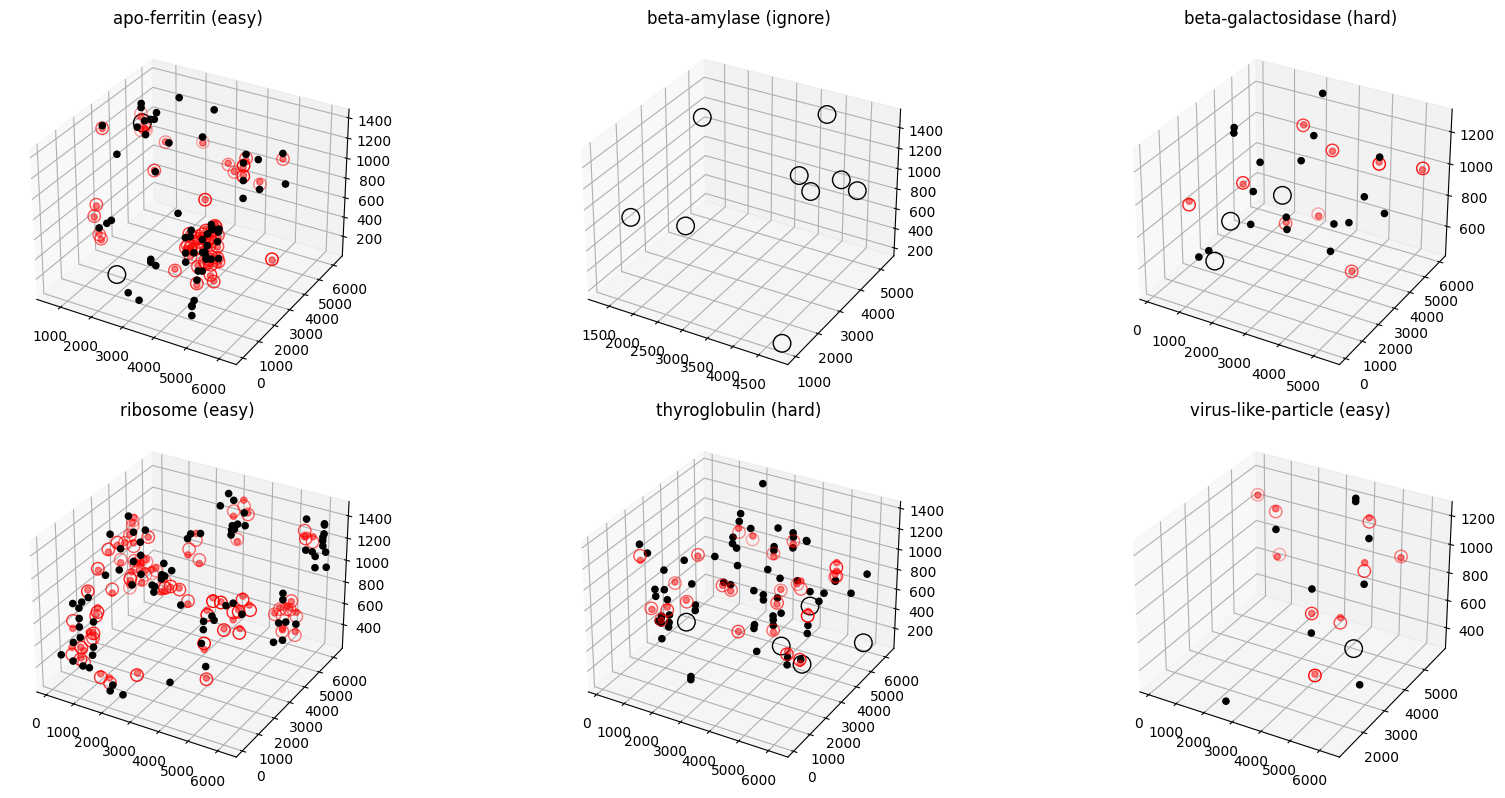

In [ ]:
# 5. 평가 및 시각화
#debug
if 1:
    if MODE=='local':
    #if 1:
        submit_df=pd.read_csv(
           'submission.csv'
            # '/kaggle/input/hengck-czii-cryo-et-weights-01/submission.csv'
        )
        gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print(gb)
        print('lb_score:',lb_score)
        print('')


        #show one ----------------------------------
        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
            print(id, p.name)
            print('\t num truth   :',len(xyz_truth) )
            print('\t num predict :',len(xyz_predict) )
            print('\t num hit  :',len(hit[0]) )
            print('\t num fp   :',len(fp) )
            print('\t num miss :',len(miss) )

            ax = fig.add_subplot(2, 3, p.label, projection='3d')
            if hit[0]:
                pt = xyz_predict[hit[0]]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
                pt = xyz_truth[hit[1]]
                ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
            if fp:
                pt = xyz_predict[fp]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
            if miss:
                pt = xyz_truth[miss]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

            ax.set_title(f'{p.name} ({p.difficulty})')

        plt.tight_layout()
        plt.show()

# Done!
We have seen how to use YOLO for 2D object detection and DFS to find the center of a sphere in space.

It takes about **10 hours** from submission to scoring. This may be an area that needs improvement.

Here are some ways to improve it further:

- Annotation and pre-processing techniques
- Improving training of YOLO models
- Good post-processing practices

### I hope you will utilize this notebook to create an interesting solution that will amaze me and everyone else! Good luck!